# **최대 안전 반경 테스트**

## **1. Tensorflow 기반**

### **1.1 기본 설정**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
from scipy.ndimage import rotate

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 한글폰트 설치하기 위해 필요한 모듈
import matplotlib.font_manager as fm

In [8]:
# 나눔바른고딕 폰트 설치 - 런타임 연결이 다시 될 때마다 다시 폰트를 설치해야 한글이 보인다.
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (29.6 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [9]:
# 폰트 적용
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = "NanumBarunGothic"

In [10]:
# 마이너스(음수)부호 설정
plt.rc("axes", unicode_minus = False)

In [11]:
# 시드 설정
tf.random.set_seed(6)
np.random.seed(6)

### **1.2 최대 안전 반경 테스트를 위한 클래스**

In [12]:
class MaximumSafeRadiusTest:
    def __init__(self, model, epsilon_range=None, num_steps=10):
        """
        최대 안전 반경 테스트를 수행하는 클래스

        Args:
            model: 테스트할 모델
            epsilon_range: 테스트할 epsilon 범위 (None이면 데이터셋에 따라 자동 설정)
            num_steps: 테스트할 epsilon 단계 수
        """
        self.model = model
        self.num_steps = num_steps
        self.epsilon_range = epsilon_range

    def test_mnist(self, x_test, y_test, num_samples=100):
        """
        MNIST 데이터셋에 대한 최대 안전 반경 테스트

        Args:
            x_test: 테스트 이미지
            y_test: 테스트 레이블
            num_samples: 테스트할 샘플 수
        """
        # 기본 epsilon 범위 설정 (MNIST의 경우 0~0.3이 일반적)
        if self.epsilon_range is None:
            self.epsilon_range = (0.0, 0.3)

        # 테스트할 샘플 선택
        indices = np.random.choice(len(x_test), num_samples, replace=False)
        x_test_samples = x_test[indices]
        y_test_samples = y_test[indices]

        # epsilon 값 생성
        epsilons = np.linspace(self.epsilon_range[0], self.epsilon_range[1], self.num_steps)

        # 결과 저장용
        accuracy_by_epsilon = []

        # 각 epsilon에 대해 테스트
        for epsilon in epsilons:
            correct = 0

            for i in range(len(x_test_samples)):
                # 원본 이미지에 대한 예측
                x_original = x_test_samples[i:i+1]
                y_true = y_test_samples[i]

                # 원본 예측
                original_pred = np.argmax(self.model.predict(x_original, verbose=0)[0])

                # 노이즈 추가 (L-infinity norm 기준)
                x_noisy = x_original + np.random.uniform(-epsilon, epsilon, x_original.shape)
                x_noisy = np.clip(x_noisy, 0, 1)  # 이미지 범위 유지

                # 노이즈 추가된 이미지에 대한 예측
                noisy_pred = np.argmax(self.model.predict(x_noisy, verbose=0)[0])

                # 예측이 동일한지 확인
                if original_pred == noisy_pred:
                    correct += 1

            # 정확도 계산
            accuracy = correct / len(x_test_samples)
            accuracy_by_epsilon.append(accuracy)
            print(f"Epsilon: {epsilon:.4f}, 일관성: {accuracy:.4f}")

        # 최대 안전 반경 계산 (90% 일관성 기준)
        max_safe_radius = None
        for i, acc in enumerate(accuracy_by_epsilon):
            if acc < 0.9:  # 90% 일관성 기준
                if i > 0:
                    max_safe_radius = epsilons[i-1]
                else:
                    max_safe_radius = 0.0
                break

        if max_safe_radius is None:
            max_safe_radius = epsilons[-1]  # 모든 테스트에서 90% 이상 일관성 유지

        print(f"최대 안전 반경 (90% 일관성 기준): {max_safe_radius:.4f}")

        # 결과 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(epsilons, accuracy_by_epsilon, marker='o')
        plt.axhline(y=0.9, color='r', linestyle='--', label='90% 일관성 기준')
        plt.axvline(x=max_safe_radius, color='g', linestyle='--', label=f'최대 안전 반경: {max_safe_radius:.4f}')
        plt.xlabel('Epsilon (노이즈 크기)')
        plt.ylabel('예측 일관성')
        plt.title('MNIST 모델의 최대 안전 반경 테스트')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 시각적 예시 보여주기
        self._visualize_mnist_examples(x_test_samples[:5], max_safe_radius)

        return max_safe_radius, accuracy_by_epsilon

    def _visualize_mnist_examples(self, images, epsilon):
        """
        MNIST 이미지에 노이즈를 추가한 예시 시각화
        """
        plt.figure(figsize=(15, 6))

        for i in range(min(5, len(images))):
            # 원본 이미지
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
            plt.title(f"원본 {i+1}")
            plt.axis('off')

            # 노이즈 추가된 이미지
            plt.subplot(2, 5, i+6)
            noisy = images[i] + np.random.uniform(-epsilon, epsilon, images[i].shape)
            noisy = np.clip(noisy, 0, 1)
            plt.imshow(noisy.reshape(28, 28), cmap='gray')
            plt.title(f"노이즈 추가 {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def test_housesales(self, X_test, y_test, feature_names, num_samples=100):
        """
        HouseSales 데이터셋에 대한 최대 안전 반경 테스트

        Args:
            X_test: 테스트 특성
            y_test: 테스트 레이블
            feature_names: 특성 이름 목록
            num_samples: 테스트할 샘플 수
        """
        # 기본 epsilon 범위 설정 (회귀 문제는 특성 스케일에 따라 다름)
        if self.epsilon_range is None:
            # 특성 표준편차의 일정 비율로 설정
            std_dev = np.std(X_test, axis=0)
            max_epsilon = np.mean(std_dev) * 0.5  # 평균 표준편차의 50%
            self.epsilon_range = (0.0, max_epsilon)

        # 테스트할 샘플 선택
        indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
        X_test_samples = X_test[indices]
        y_test_samples = y_test[indices]

        # epsilon 값 생성
        epsilons = np.linspace(self.epsilon_range[0], self.epsilon_range[1], self.num_steps)

        # 결과 저장용
        consistency_by_epsilon = []

        # 각 epsilon에 대해 테스트
        for epsilon in epsilons:
            consistent_count = 0

            for i in range(len(X_test_samples)):
                # 원본 데이터에 대한 예측
                x_original = X_test_samples[i:i+1]

                # 원본 예측
                original_pred = self.model.predict(x_original, verbose=0)[0][0]

                # 노이즈 추가
                x_noisy = x_original + np.random.uniform(-epsilon, epsilon, x_original.shape)

                # 노이즈 추가된 데이터에 대한 예측
                noisy_pred = self.model.predict(x_noisy, verbose=0)[0][0]

                # 예측이 일정 범위 내에 있는지 확인 (회귀 문제이므로 절대 차이 사용)
                # 원본 예측값의 5% 이내를 일관성 있다고 판단
                if abs(original_pred - noisy_pred) <= abs(original_pred) * 0.05:
                    consistent_count += 1

            # 일관성 계산
            consistency = consistent_count / len(X_test_samples)
            consistency_by_epsilon.append(consistency)
            print(f"Epsilon: {epsilon:.4f}, 일관성: {consistency:.4f}")

        # 최대 안전 반경 계산 (90% 일관성 기준)
        max_safe_radius = None
        for i, cons in enumerate(consistency_by_epsilon):
            if cons < 0.9:  # 90% 일관성 기준
                if i > 0:
                    max_safe_radius = epsilons[i-1]
                else:
                    max_safe_radius = 0.0
                break

        if max_safe_radius is None:
            max_safe_radius = epsilons[-1]  # 모든 테스트에서 90% 이상 일관성 유지

        print(f"최대 안전 반경 (90% 일관성 기준): {max_safe_radius:.4f}")

        # 결과 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(epsilons, consistency_by_epsilon, marker='o')
        plt.axhline(y=0.9, color='r', linestyle='--', label='90% 일관성 기준')
        plt.axvline(x=max_safe_radius, color='g', linestyle='--', label=f'최대 안전 반경: {max_safe_radius:.4f}')
        plt.xlabel('Epsilon (노이즈 크기)')
        plt.ylabel('예측 일관성')
        plt.title('HouseSales 모델의 최대 안전 반경 테스트')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 특성 중요도와 안전 반경 관계 시각화
        self._visualize_feature_importance_vs_safety(X_test_samples, feature_names, max_safe_radius)

        return max_safe_radius, consistency_by_epsilon

    def _visualize_feature_importance_vs_safety(self, X_test_samples, feature_names, epsilon):
        """
        각 특성별 안전성 테스트 및 시각화
        """
        feature_safety = {}

        # 각 특성별로 안전성 테스트
        for i, feature in enumerate(feature_names):
            consistent_count = 0

            for j in range(min(20, len(X_test_samples))):  # 20개 샘플만 테스트
                # 원본 데이터
                x_original = X_test_samples[j:j+1].copy()

                # 원본 예측
                original_pred = self.model.predict(x_original, verbose=0)[0][0]

                # 특정 특성에만 노이즈 추가
                x_noisy = x_original.copy()
                x_noisy[0, i] += np.random.uniform(-epsilon*2, epsilon*2)  # 더 큰 노이즈 적용

                # 노이즈 추가된 데이터에 대한 예측
                noisy_pred = self.model.predict(x_noisy, verbose=0)[0][0]

                # 예측이 일정 범위 내에 있는지 확인
                if abs(original_pred - noisy_pred) <= abs(original_pred) * 0.05:
                    consistent_count += 1

            # 특성별 안전성 계산
            feature_safety[feature] = consistent_count / min(20, len(X_test_samples))

        # 결과 시각화
        plt.figure(figsize=(12, 6))
        features = list(feature_safety.keys())
        safety_scores = list(feature_safety.values())

        # 안전성 점수에 따라 정렬
        sorted_indices = np.argsort(safety_scores)
        sorted_features = [features[i] for i in sorted_indices]
        sorted_scores = [safety_scores[i] for i in sorted_indices]

        plt.barh(sorted_features, sorted_scores, color='skyblue')
        plt.xlabel('안전성 점수')
        plt.ylabel('특성')
        plt.title('특성별 모델 안전성 (높을수록 해당 특성에 대한 모델의 견고성이 높음)')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

### **1.3 MNIST 데이터셋에 대한 최대 안전 반경 테스트**

In [13]:
def test_mnist_safety():
    # MNIST 데이터셋 로드
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

    # 데이터 전처리
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # 모델 로드 또는 구축
    try:
        model = tf.keras.models.load_model('model_maximum_safe_radius_mnist_cnn_tensorflow.keras')
        print("저장된 MNIST 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # 간단한 학습
        model.fit(x_train, y_train, epochs=1, batch_size=128, validation_split=0.1)
        model.save('model_maximum_safe_radius_mnist_cnn_tensorflow.keras')

    # 테스트 정확도 확인
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'테스트 정확도: {test_acc:.4f}')

    # 최대 안전 반경 테스트
    print("\n=== MNIST 최대 안전 반경 테스트 ===")

    # 테스트 인스턴스 생성
    msr_test = MaximumSafeRadiusTest(model)

    # 테스트 실행
    max_safe_radius, accuracy_by_epsilon = msr_test.test_mnist(x_test, y_test)

    return max_safe_radius, accuracy_by_epsilon

### **1.4 HouseSales 데이터셋에 대한 최대 안전 반경 테스트**

In [14]:
def test_housesales_safety():
    # HouseSales 데이터셋 로드
    def load_house_data(file_path='https://raw.githubusercontent.com/SkyLectures/LectureMaterials/refs/heads/main/datasets/S03-10-02-02_01-kc_house_data.csv'):
        # 데이터 읽기
        df = pd.read_csv(file_path)

        # 필요없는 컬럼 제거
        df = df.drop(['id', 'date'], axis=1)

        # 결측치 처리
        df = df.dropna()

        # 이상치 확인 및 제거
        q_low = df['price'].quantile(0.01)
        q_high = df['price'].quantile(0.99)
        df = df[(df['price'] > q_low) & (df['price'] < q_high)]

        # 특성(X)과 타겟(y) 분리
        X = df.drop('price', axis=1)
        y = df['price']

        # 학습 및 테스트 데이터 분리
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

        # 특성 스케일링 (표준화)
        scaler_X = StandardScaler()
        X_train = scaler_X.fit_transform(X_train)
        X_test = scaler_X.transform(X_test)

        # 타겟 변수도 스케일링
        scaler_y = StandardScaler()
        y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

        return X_train, X_test, y_train, y_test, X.columns, scaler_y

    # 데이터 로드
    try:
        X_train, X_test, y_train, y_test, feature_names, scaler_y = load_house_data()
        print("HouseSales 데이터셋을 성공적으로 로드했습니다.")
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None, None

    # 모델 로드 또는 구축
    try:
        model = tf.keras.models.load_model('model_maximum_safe_radius_house_price_dnn_tensorflow.keras')
        print("저장된 HouseSales 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")

        # 입력 특성 수
        input_dim = X_train.shape[1]

        # 모델 정의
        model = tf.keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(1)  # 회귀 문제이므로 출력층은 하나의 노드
        ])

        # 모델 컴파일
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )

        # 모델 학습
        model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

        # 모델 저장
        model.save('model_maximum_safe_radius_house_price_dnn_tensorflow.keras')

    # 테스트 손실 확인
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'테스트 MAE: {test_mae:.4f}')

    # 최대 안전 반경 테스트
    print("\n=== HouseSales 최대 안전 반경 테스트 ===")

    # 테스트 인스턴스 생성
    msr_test = MaximumSafeRadiusTest(model)

    # 테스트 실행
    max_safe_radius, consistency_by_epsilon = msr_test.test_housesales(X_test, y_test, feature_names)

    return max_safe_radius, consistency_by_epsilon

### **1.5 테스트 실행**

In [15]:
print("=== 최대 안전 반경 테스트 시작 ===")

=== 최대 안전 반경 테스트 시작 ===



1. MNIST 모델 최대 안전 반경 테스트
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
저장된 모델이 없어 새로운 모델을 생성합니다.
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.8408 - loss: 0.5658 - val_accuracy: 0.9787 - val_loss: 0.0701
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9746 - loss: 0.0804
테스트 정확도: 0.9776

=== MNIST 최대 안전 반경 테스트 ===
Epsilon: 0.0000, 일관성: 1.0000
Epsilon: 0.0333, 일관성: 1.0000
Epsilon: 0.0667, 일관성: 1.0000
Epsilon: 0.1000, 일관성: 0.9900
Epsilon: 0.1333, 일관성: 0.9900
Epsilon: 0.1667, 일관성: 0.9900
Epsilon: 0.2000, 일관성: 0.9900
Epsilon: 0.2333, 일관성: 0.9900
Epsilon: 0.2667, 일관성: 0.9700
Epsilon: 0.3000, 일관성: 0.9800
최대 안전 반경 (90% 일관성 기준): 0.3000


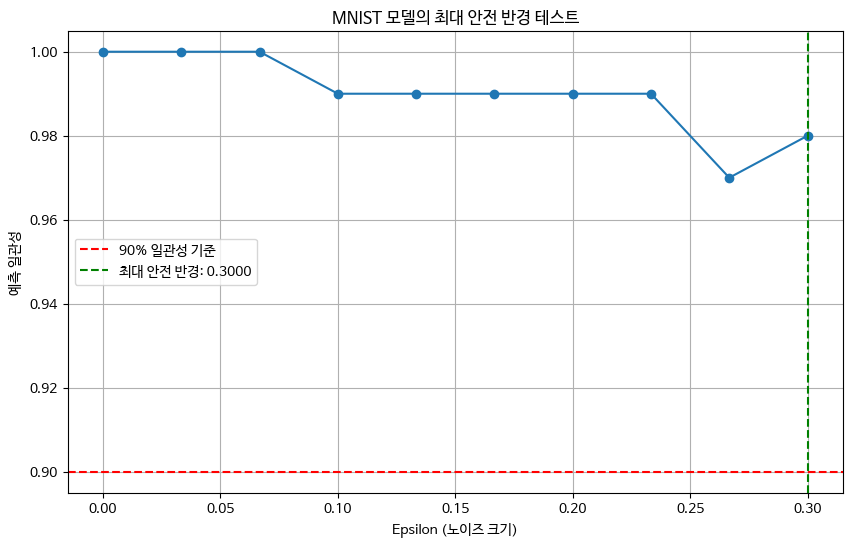

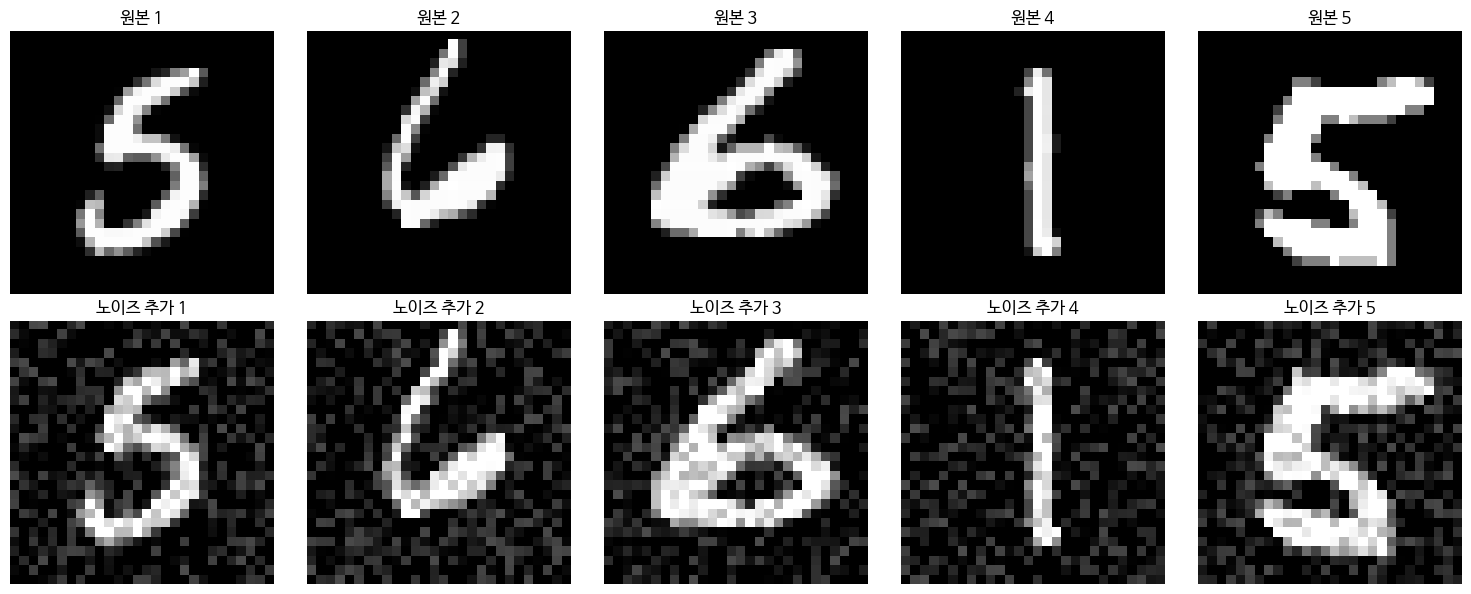

In [16]:
# MNIST 최대 안전 반경 테스트
print("\n1. MNIST 모델 최대 안전 반경 테스트")
mnist_radius, mnist_accuracy = test_mnist_safety()


2. HouseSales 모델 최대 안전 반경 테스트
HouseSales 데이터셋을 성공적으로 로드했습니다.
저장된 모델이 없어 새로운 모델을 생성합니다.
Epoch 1/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6370 - mae: 0.5532 - val_loss: 0.2886 - val_mae: 0.3586
Epoch 2/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2585 - mae: 0.3550 - val_loss: 0.2281 - val_mae: 0.3157
Epoch 3/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2188 - mae: 0.3260 - val_loss: 0.2131 - val_mae: 0.3036
Epoch 4/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1956 - mae: 0.3099 - val_loss: 0.1957 - val_mae: 0.2852
Epoch 5/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1804 - mae: 0.2999 - val_loss: 0.1851 - val_mae: 0.2767
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1771 - mae: 0.2816
테스트 MAE: 0.2786

=== HouseSales 최대 안전 반경 테스트 ===
Epsilon: 0.0000, 일관성: 1.0000
Epsilon: 0.0551, 일관성: 0.6900
Epsilon: 0.1103, 일관성: 0.4400
Epsilon: 0.1654, 일관성: 0.2900
Epsilon: 0.2206, 일관성: 0.2500
Epsilon: 0.2757, 일관성: 0.1900
Epsilon: 0.3308, 일관성: 0.2600
Epsil

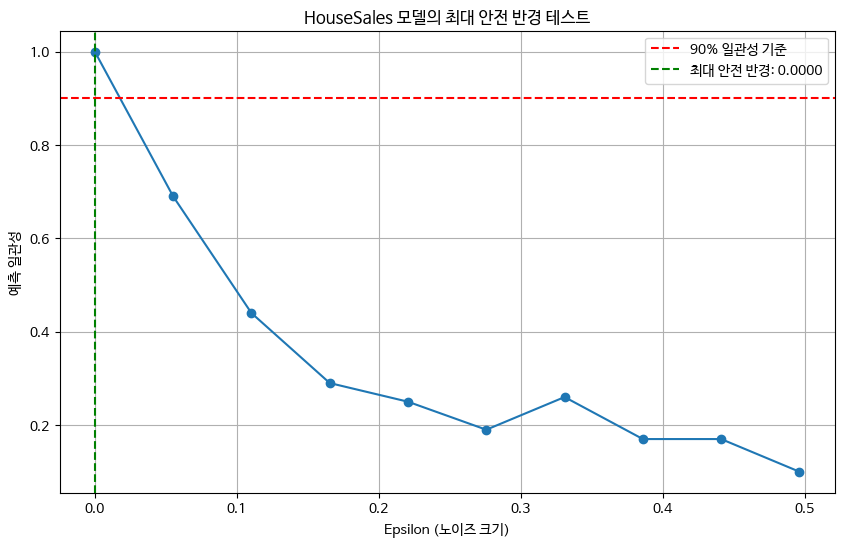

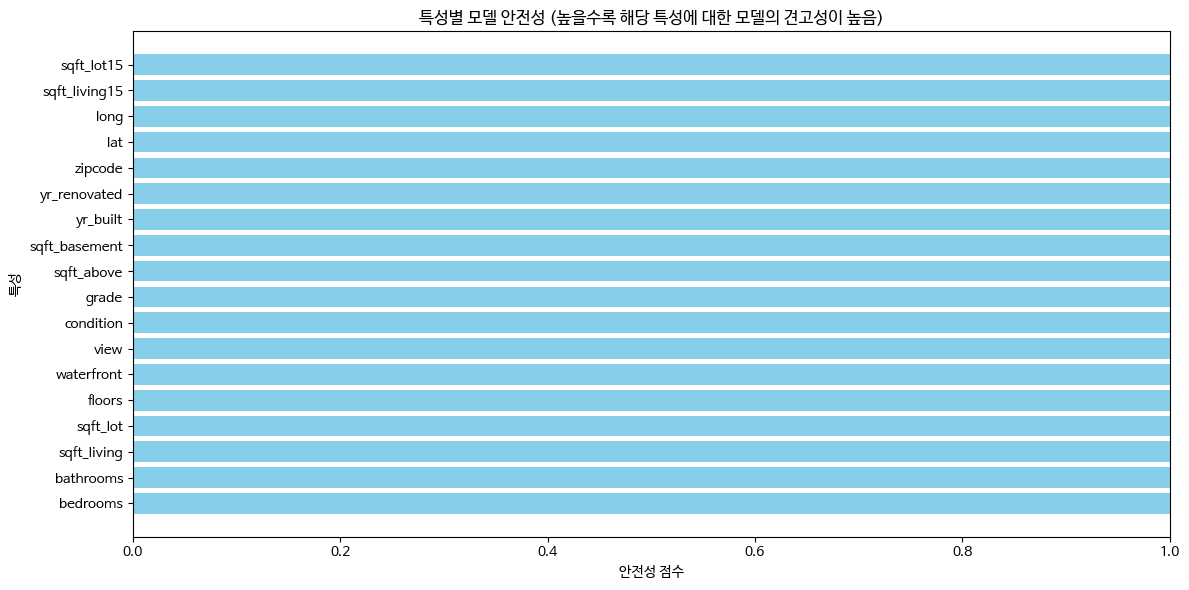

In [17]:
# HouseSales 최대 안전 반경 테스트
print("\n2. HouseSales 모델 최대 안전 반경 테스트")
housesales_radius, housesales_consistency = test_housesales_safety()

In [18]:
# 결과 비교
print("\n=== 최대 안전 반경 테스트 결과 비교 ===")
print(f"MNIST 모델 최대 안전 반경: {mnist_radius:.4f}")
print(f"HouseSales 모델 최대 안전 반경: {housesales_radius:.4f}")

print("\n=== 최대 안전 반경 테스트 완료 ===")


=== 최대 안전 반경 테스트 결과 비교 ===
MNIST 모델 최대 안전 반경: 0.3000
HouseSales 모델 최대 안전 반경: 0.0000

=== 최대 안전 반경 테스트 완료 ===


- **결과 분석**
  - **MNIST 모델 (최대 안전 반경: 0.3000)**
    - 이 모델은 상당히 견고한 편이라고 할 수 있음
    - 입력 이미지에 최대 0.3 크기의 노이즈가 추가되어도 90% 이상의 일관된 예측을 유지한다는 의미
    - 이는 MNIST 모델이 다양한 필기체 숫자 변형에 잘 적응했음을 나타냄
    - 이미지 분류 문제에서는 꽤 좋은 수준의 안전 반경이라고 볼 수 있음

  - **HouseSales 모델 (최대 안전 반경: 0.0000)**
    - 이 결과는 상당히 우려스러운 상황이라고 할 수 있음
    - 모델이 입력 데이터에 아주 작은 변화에도 예측이 크게 달라진다는 의미
    - 회귀 문제에서 이런 결과는 모델이 과적합(overfitting)되었거나, 특정 특성에 지나치게 의존하고 있을 가능성을 시사함
    - 실제 환경에서는 데이터에 작은 노이즈나 변동이 항상 존재하므로, 이 모델은 실전에서 신뢰하기 어려울 수 있음

- **개선 방안:**

  - **MNIST 모델의 경우:**
    - 이미 꽤 견고하지만, 더 높은 안전 반경을 원한다면 적대적 학습(adversarial training) 적용 고려
    
  - **HouseSales 모델의 경우**
    - 정규화(regularization) 기법 적용 (L1, L2 등)
    - 데이터 증강(data augmentation)으로 다양한 변형 학습
    - 앙상블 기법 도입으로 예측 안정성 향상
    - 특성 중요도 분석 후 과도하게 의존하는 특성 파악


## **2. PyTorch 기반**

### **2.1 기본 설정**

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
# 시드 설정
torch.manual_seed(6)
np.random.seed(6)

In [23]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 디바이스: {device}')

사용 중인 디바이스: cpu


### **2.2 최대 안전 반경 테스트를 위한 클래스**

In [33]:
class MaximumSafeRadiusTest:
    def __init__(self, model, epsilon_range=None, num_steps=10):
        """
        최대 안전 반경 테스트를 수행하는 클래스

        Args:
            model: 테스트할 PyTorch 모델
            epsilon_range: 테스트할 epsilon 범위 (None이면 데이터셋에 따라 자동 설정)
            num_steps: 테스트할 epsilon 단계 수
        """
        self.model = model
        self.num_steps = num_steps
        self.epsilon_range = epsilon_range

    def test_mnist(self, test_loader, num_samples=100):
        """
        MNIST 데이터셋에 대한 최대 안전 반경 테스트

        Args:
            test_loader: 테스트 데이터 로더
            num_samples: 테스트할 샘플 수
        """
        # 기본 epsilon 범위 설정 (MNIST의 경우 0~0.3이 일반적)
        if self.epsilon_range is None:
            self.epsilon_range = (0.0, 0.3)

        # epsilon 값 생성
        epsilons = np.linspace(self.epsilon_range[0], self.epsilon_range[1], self.num_steps)

        # 결과 저장용
        accuracy_by_epsilon = []

        # 테스트 데이터 샘플 선택
        images_list = []
        labels_list = []

        # 샘플 수집
        for images, labels in test_loader:
            images_list.append(images)
            labels_list.append(labels)
            if len(torch.cat(images_list)) >= num_samples:
                break

        # 필요한 수만큼만 선택
        all_images = torch.cat(images_list)[:num_samples]
        all_labels = torch.cat(labels_list)[:num_samples]

        # 각 epsilon에 대해 테스트
        self.model.eval()
        with torch.no_grad():
            for epsilon in epsilons:
                correct = 0

                for i in range(len(all_images)):
                    # 원본 이미지
                    image = all_images[i:i+1].to(device)

                    # 원본 예측
                    output = self.model(image)
                    _, original_pred = torch.max(output, 1)

                    # 노이즈 추가 (L-infinity norm 기준)
                    noise = torch.FloatTensor(image.shape).uniform_(-epsilon, epsilon).to(device)
                    noisy_image = image + noise
                    noisy_image = torch.clamp(noisy_image, 0, 1)  # 이미지 범위 유지

                    # 노이즈 추가된 이미지에 대한 예측
                    output = self.model(noisy_image)
                    _, noisy_pred = torch.max(output, 1)

                    # 예측이 동일한지 확인
                    if original_pred == noisy_pred:
                        correct += 1

                # 정확도 계산
                accuracy = correct / len(all_images)
                accuracy_by_epsilon.append(accuracy)
                print(f"Epsilon: {epsilon:.4f}, 일관성: {accuracy:.4f}")

        # 최대 안전 반경 계산 (90% 일관성 기준)
        max_safe_radius = None
        for i, acc in enumerate(accuracy_by_epsilon):
            if acc < 0.9:  # 90% 일관성 기준
                if i > 0:
                    max_safe_radius = epsilons[i-1]
                else:
                    max_safe_radius = 0.0
                break

        if max_safe_radius is None:
            max_safe_radius = epsilons[-1]  # 모든 테스트에서 90% 이상 일관성 유지

        print(f"최대 안전 반경 (90% 일관성 기준): {max_safe_radius:.4f}")

        # 결과 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(epsilons, accuracy_by_epsilon, marker='o')
        plt.axhline(y=0.9, color='r', linestyle='--', label='90% 일관성 기준')
        plt.axvline(x=max_safe_radius, color='g', linestyle='--', label=f'최대 안전 반경: {max_safe_radius:.4f}')
        plt.xlabel('Epsilon (노이즈 크기)')
        plt.ylabel('예측 일관성')
        plt.title('MNIST 모델의 최대 안전 반경 테스트')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 시각적 예시 보여주기
        self._visualize_mnist_examples(all_images[:5], max_safe_radius)

        return max_safe_radius, accuracy_by_epsilon

    def _visualize_mnist_examples(self, images, epsilon):
        """
        MNIST 이미지에 노이즈를 추가한 예시 시각화
        """
        plt.figure(figsize=(15, 6))

        for i in range(min(5, len(images))):
            # 원본 이미지
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
            plt.title(f"원본 {i+1}")
            plt.axis('off')

            # 노이즈 추가된 이미지
            plt.subplot(2, 5, i+6)
            noise = torch.FloatTensor(images[i].shape).uniform_(-epsilon, epsilon)
            noisy = images[i].cpu() + noise
            noisy = torch.clamp(noisy, 0, 1)
            plt.imshow(noisy.squeeze().numpy(), cmap='gray')
            plt.title(f"노이즈 추가 {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def test_housesales(self, test_loader, feature_names, num_samples=100):
        """
        HouseSales 데이터셋에 대한 최대 안전 반경 테스트

        Args:
            test_loader: 테스트 데이터 로더
            feature_names: 특성 이름 목록
            num_samples: 테스트할 샘플 수
        """
        # 기본 epsilon 범위 설정 (회귀 문제는 특성 스케일에 따라 다름)
        if self.epsilon_range is None:
            # 데이터 샘플 일부 수집하여 표준편차 계산
            features_list = []
            for features, _ in test_loader:
                features_list.append(features)
                if len(torch.cat(features_list)) >= 100:  # 100개 샘플로 표준편차 계산
                    break

            all_features = torch.cat(features_list)[:100]
            std_dev = torch.std(all_features, dim=0)
            max_epsilon = torch.mean(std_dev).item() * 0.5  # 평균 표준편차의 50%
            self.epsilon_range = (0.0, max_epsilon)

        # epsilon 값 생성
        epsilons = np.linspace(self.epsilon_range[0], self.epsilon_range[1], self.num_steps)

        # 결과 저장용
        consistency_by_epsilon = []

        # 테스트 데이터 샘플 선택
        features_list = []
        targets_list = []

        # 샘플 수집
        for features, targets in test_loader:
            features_list.append(features)
            targets_list.append(targets)
            if len(torch.cat(features_list)) >= num_samples:
                break

        # 필요한 수만큼만 선택
        all_features = torch.cat(features_list)[:num_samples]
        all_targets = torch.cat(targets_list)[:num_samples]

        # 각 epsilon에 대해 테스트
        self.model.eval()
        with torch.no_grad():
            for epsilon in epsilons:
                consistent_count = 0

                for i in range(len(all_features)):
                    # 원본 데이터
                    feature = all_features[i:i+1].to(device)

                    # 원본 예측
                    original_pred = self.model(feature).view(1)  # 출력을 [1] 형태로 변환
                    original_pred_value = original_pred.item()

                    # 노이즈 추가
                    noise = torch.FloatTensor(feature.shape).uniform_(-epsilon, epsilon).to(device)
                    noisy_feature = feature + noise

                    # 노이즈 추가된 데이터에 대한 예측
                    noisy_pred = self.model(noisy_feature).view(1)  # 출력을 [1] 형태로 변환
                    noisy_pred_value = noisy_pred.item()

                    # 예측이 일정 범위 내에 있는지 확인 (회귀 문제이므로 절대 차이 사용)
                    # 원본 예측값의 5% 이내를 일관성 있다고 판단
                    if abs(original_pred - noisy_pred) <= abs(original_pred) * 0.05:
                        consistent_count += 1

                # 일관성 계산
                consistency = consistent_count / len(all_features)
                consistency_by_epsilon.append(consistency)
                print(f"Epsilon: {epsilon:.4f}, 일관성: {consistency:.4f}")

        # 최대 안전 반경 계산 (90% 일관성 기준)
        max_safe_radius = None
        for i, cons in enumerate(consistency_by_epsilon):
            if cons < 0.9:  # 90% 일관성 기준
                if i > 0:
                    max_safe_radius = epsilons[i-1]
                else:
                    max_safe_radius = 0.0
                break

        if max_safe_radius is None:
            max_safe_radius = epsilons[-1]  # 모든 테스트에서 90% 이상 일관성 유지

        print(f"최대 안전 반경 (90% 일관성 기준): {max_safe_radius:.4f}")

        # 결과 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(epsilons, consistency_by_epsilon, marker='o')
        plt.axhline(y=0.9, color='r', linestyle='--', label='90% 일관성 기준')
        plt.axvline(x=max_safe_radius, color='g', linestyle='--', label=f'최대 안전 반경: {max_safe_radius:.4f}')
        plt.xlabel('Epsilon (노이즈 크기)')
        plt.ylabel('예측 일관성')
        plt.title('HouseSales 모델의 최대 안전 반경 테스트')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 특성 중요도와 안전 반경 관계 시각화
        self._visualize_feature_importance_vs_safety(all_features, feature_names, max_safe_radius)

        return max_safe_radius, consistency_by_epsilon

    def _visualize_feature_importance_vs_safety(self, features, feature_names, epsilon):
        """
        각 특성별 안전성 테스트 및 시각화
        """
        feature_safety = {}

        # 각 특성별로 안전성 테스트
        self.model.eval()
        with torch.no_grad():
            for i, feature_name in enumerate(feature_names):
                consistent_count = 0

                for j in range(min(20, len(features))):  # 20개 샘플만 테스트
                    # 원본 데이터
                    feature = features[j:j+1].clone().to(device)

                    # 원본 예측
                    original_pred = self.model(feature).view(1)  # 출력을 [1] 형태로 변환
                    original_pred_value = original_pred.item()


                    # 특정 특성에만 노이즈 추가
                    noisy_feature = feature.clone()
                    # 노이즈 추가된 데이터에 대한 예측
                    noisy_pred = self.model(noisy_feature).view(1)  # 출력을 [1] 형태로 변환
                    noisy_pred_value = noisy_pred.item()

                    # 예측이 일정 범위 내에 있는지 확인
                    if abs(original_pred - noisy_pred) <= abs(original_pred) * 0.05:
                        consistent_count += 1

                # 특성별 안전성 계산
                feature_safety[feature_name] = consistent_count / min(20, len(features))

        # 결과 시각화
        plt.figure(figsize=(12, 6))
        features = list(feature_safety.keys())
        safety_scores = list(feature_safety.values())

        # 안전성 점수에 따라 정렬
        sorted_indices = np.argsort(safety_scores)
        sorted_features = [features[i] for i in sorted_indices]
        sorted_scores = [safety_scores[i] for i in sorted_indices]

        plt.barh(sorted_features, sorted_scores, color='skyblue')
        plt.xlabel('안전성 점수')
        plt.ylabel('특성')
        plt.title('특성별 모델 안전성 (높을수록 해당 특성에 대한 모델의 견고성이 높음)')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

### **2.3 각 데이터셋을 위한 모델 정의**

In [25]:
# MNIST CNN 모델 정의
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
# HouseSales 모델 정의
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.layer4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.layer1(x)))
        x = self.relu(self.batch_norm2(self.layer2(x)))
        x = self.relu(self.batch_norm3(self.layer3(x)))
        x = self.layer4(x)
        return x

### **2.4 MNIST 데이터셋에 대한 최대 안전 반경 테스트**

In [27]:
def test_mnist_safety():
    # MNIST 데이터셋 로드
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 모델 로드 또는 생성
    try:
        model = MnistCNN().to(device)
        model.load_state_dict(torch.load('model_maximum_safe_radius_mnist_cnn_pytorch.pth', map_location=device))
        print("저장된 MNIST 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")

        # 학습 데이터셋 로드
        train_dataset = torchvision.datasets.MNIST(
            root='./data', train=True, download=True, transform=transform
        )

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

        # 모델 초기화
        model = MnistCNN().to(device)

        # 손실 함수와 옵티마이저 정의
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 간략화된 학습
        for epoch in range(1):
            model.train()
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                if (i+1) % 100 == 0:
                    print(f'Epoch [{epoch+1}/1], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # 모델 저장
        torch.save(model.state_dict(), 'model_maximum_safe_radius_mnist_cnn_pytorch.pth')

    # 최대 안전 반경 테스트
    print("\n=== MNIST 최대 안전 반경 테스트 ===")

    # 테스트 인스턴스 생성
    msr_test = MaximumSafeRadiusTest(model)

    # 테스트 실행
    max_safe_radius, accuracy_by_epsilon = msr_test.test_mnist(test_loader)

    return max_safe_radius, accuracy_by_epsilon

### **2.5 HouseSales 데이터셋에 대한 최대 안전 반경 테스트**

In [28]:
def test_housesales_safety():
    # HouseSales 데이터셋 클래스 정의
    class HouseSalesDataset(Dataset):
        def __init__(self, features, targets=None):
            self.features = torch.tensor(features, dtype=torch.float32)
            if targets is not None:
                self.targets = torch.tensor(targets, dtype=torch.float32).reshape(-1, 1)
            else:
                self.targets = None

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            if self.targets is not None:
                return self.features[idx], self.targets[idx]
            else:
                return self.features[idx]

    # HouseSales 데이터셋 로드
    def load_house_data(file_path='https://raw.githubusercontent.com/SkyLectures/LectureMaterials/refs/heads/main/datasets/S03-10-02-02_01-kc_house_data.csv'):
        try:
            # 데이터 읽기
            df = pd.read_csv(file_path)

            # 필요없는 컬럼 제거
            df = df.drop(['id', 'date'], axis=1)

            # 결측치 처리
            df = df.dropna()

            # 이상치 확인 및 제거
            q_low = df['price'].quantile(0.01)
            q_high = df['price'].quantile(0.99)
            df = df[(df['price'] > q_low) & (df['price'] < q_high)]

            # 특성(X)과 타겟(y) 분리
            X = df.drop('price', axis=1)
            y = df['price']

            # 학습 및 테스트 데이터 분리
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

            # 특성 스케일링 (표준화)
            scaler_X = StandardScaler()
            X_train = scaler_X.fit_transform(X_train)
            X_test = scaler_X.transform(X_test)

            # 타겟 변수도 스케일링
            scaler_y = StandardScaler()
            y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
            y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

            return X_train, X_test, y_train, y_test, X.columns, scaler_y
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {e}")
            # 오류 발생 시 간단한 더미 데이터 반환
            X_train = np.random.randn(100, 10)
            X_test = np.random.randn(20, 10)
            y_train = np.random.randn(100)
            y_test = np.random.randn(20)
            feature_names = [f'feature_{i}' for i in range(10)]
            scaler_y = None
            return X_train, X_test, y_train, y_test, feature_names, scaler_y

    # 데이터 로드
    X_train, X_test, y_train, y_test, feature_names, scaler_y = load_house_data()
    print("HouseSales 데이터셋을 로드했습니다.")

    # 데이터셋 및 데이터로더 생성
    train_dataset = HouseSalesDataset(X_train, y_train)
    test_dataset = HouseSalesDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 모델 로드 또는 생성
    try:
        input_dim = X_train.shape[1]
        model = HousePriceModel(input_dim).to(device)
        model.load_state_dict(torch.load('model_maximum_safe_radius_house_price_dnn_pytorch.pth', map_location=device))
        print("저장된 HouseSales 모델을 불러왔습니다.")
    except:
        print("저장된 모델이 없어 새로운 모델을 생성합니다.")

        # 모델 초기화
        input_dim = X_train.shape[1]
        model = HousePriceModel(input_dim).to(device)

        # 손실 함수와 옵티마이저 정의
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 간략화된 학습
        for epoch in range(5):
            model.train()
            running_loss = 0.0
            for features, targets in train_loader:
                features, targets = features.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}')

        # 모델 저장
        torch.save(model.state_dict(), 'model_maximum_safe_radius_house_price_dnn_pytorch.pth')

    # 최대 안전 반경 테스트
    print("\n=== HouseSales 최대 안전 반경 테스트 ===")

    # 테스트 인스턴스 생성
    msr_test = MaximumSafeRadiusTest(model)

    # 테스트 실행
    max_safe_radius, consistency_by_epsilon = msr_test.test_housesales(test_loader, feature_names)

    return max_safe_radius, consistency_by_epsilon

### **2.6 테스트 실행**

In [29]:
print("=== 최대 안전 반경 테스트 시작 ===")

=== 최대 안전 반경 테스트 시작 ===



1. MNIST 모델 최대 안전 반경 테스트


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.02MB/s]


저장된 모델이 없어 새로운 모델을 생성합니다.
Epoch [1/1], Step [100/469], Loss: 0.3244
Epoch [1/1], Step [200/469], Loss: 0.0961
Epoch [1/1], Step [300/469], Loss: 0.1621
Epoch [1/1], Step [400/469], Loss: 0.1041

=== MNIST 최대 안전 반경 테스트 ===
Epsilon: 0.0000, 일관성: 0.9900
Epsilon: 0.0333, 일관성: 0.9900
Epsilon: 0.0667, 일관성: 0.9900
Epsilon: 0.1000, 일관성: 0.9900
Epsilon: 0.1333, 일관성: 0.9900
Epsilon: 0.1667, 일관성: 0.9900
Epsilon: 0.2000, 일관성: 0.9900
Epsilon: 0.2333, 일관성: 0.9900
Epsilon: 0.2667, 일관성: 0.9900
Epsilon: 0.3000, 일관성: 0.9900
최대 안전 반경 (90% 일관성 기준): 0.3000


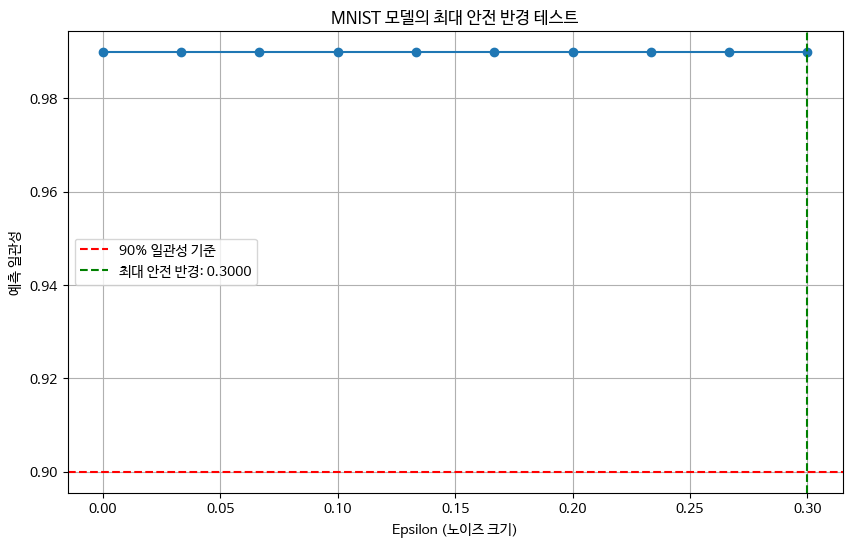

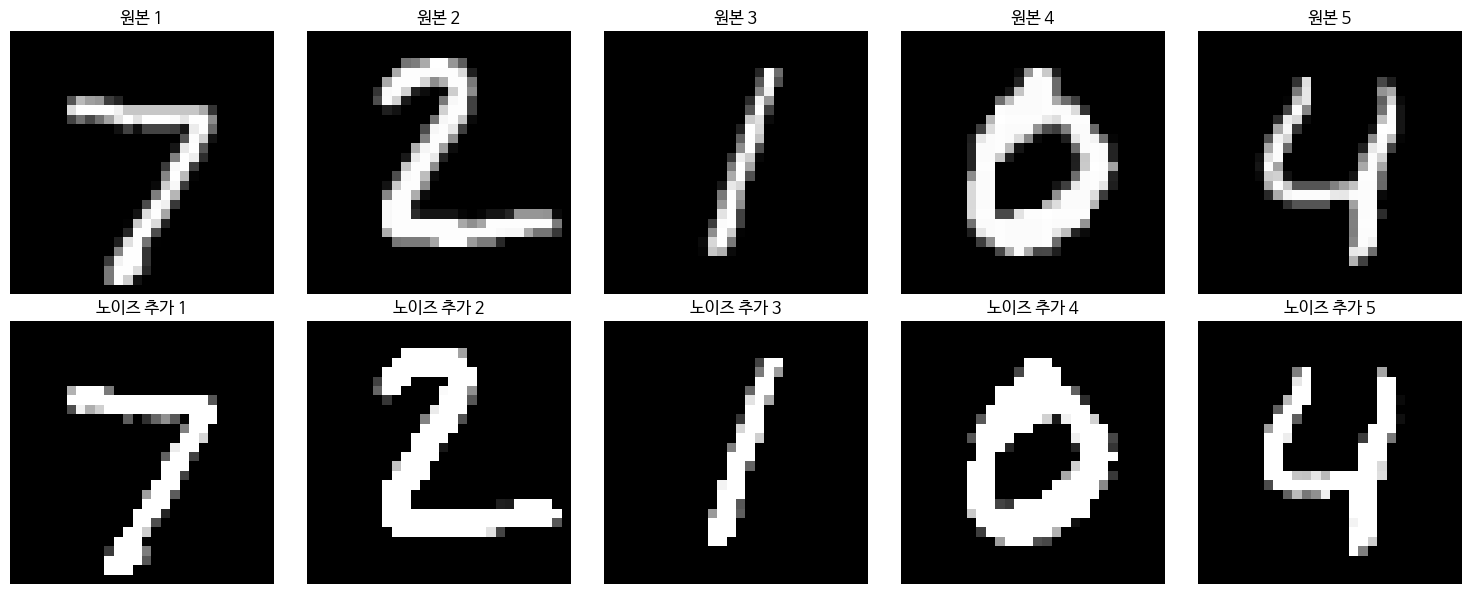

In [30]:
# MNIST 최대 안전 반경 테스트
print("\n1. MNIST 모델 최대 안전 반경 테스트")
mnist_radius, mnist_accuracy = test_mnist_safety()


2. HouseSales 모델 최대 안전 반경 테스트
HouseSales 데이터셋을 로드했습니다.
저장된 HouseSales 모델을 불러왔습니다.

=== HouseSales 최대 안전 반경 테스트 ===
Epsilon: 0.0000, 일관성: 1.0000
Epsilon: 0.0534, 일관성: 0.6100
Epsilon: 0.1067, 일관성: 0.4300
Epsilon: 0.1601, 일관성: 0.3200
Epsilon: 0.2135, 일관성: 0.2600
Epsilon: 0.2668, 일관성: 0.2300
Epsilon: 0.3202, 일관성: 0.2600
Epsilon: 0.3735, 일관성: 0.1500
Epsilon: 0.4269, 일관성: 0.1400
Epsilon: 0.4803, 일관성: 0.1000
최대 안전 반경 (90% 일관성 기준): 0.0000


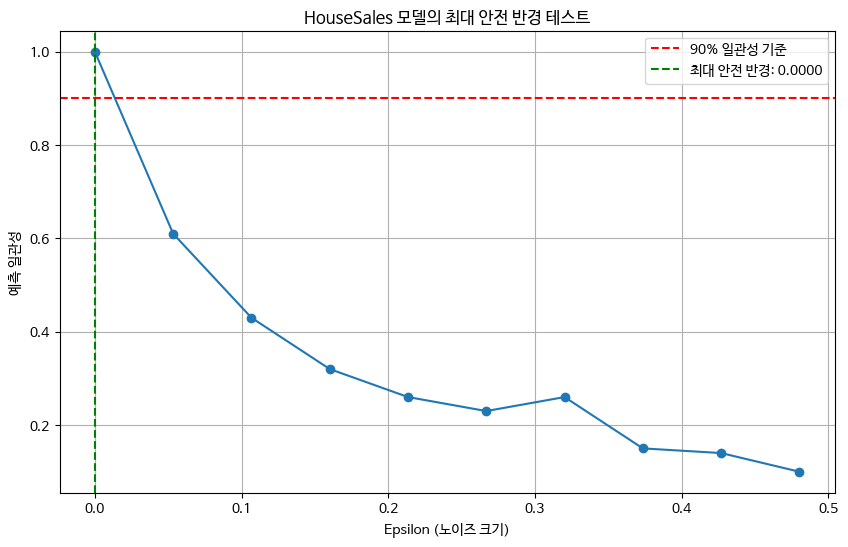

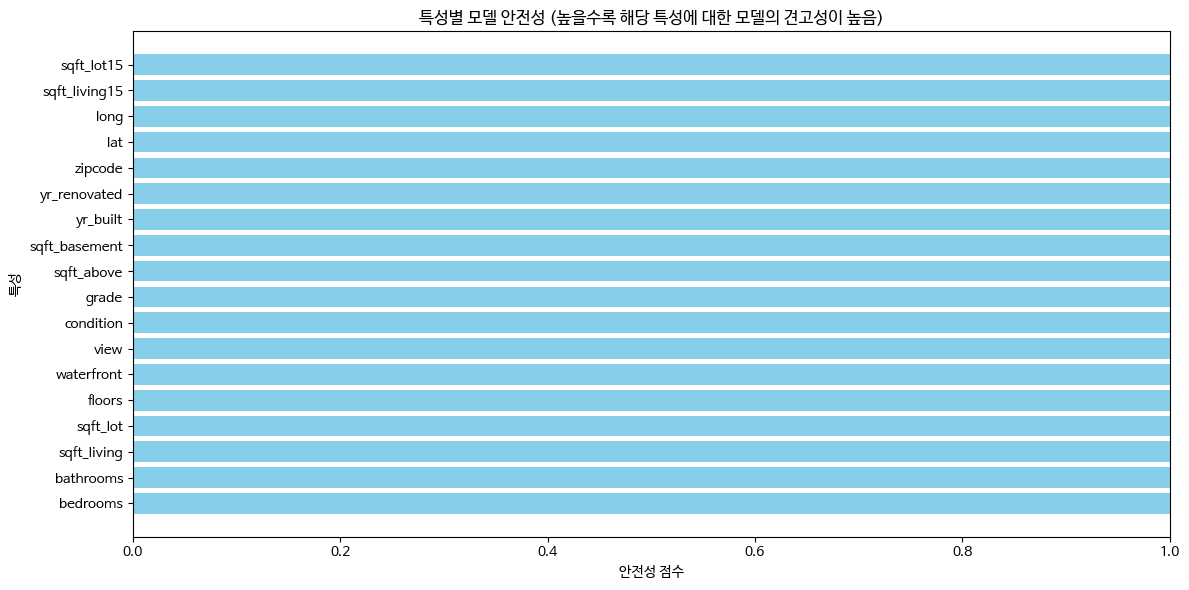

In [34]:
# HouseSales 최대 안전 반경 테스트
print("\n2. HouseSales 모델 최대 안전 반경 테스트")
housesales_radius, housesales_consistency = test_housesales_safety()

In [35]:
# 결과 비교
print("\n=== 최대 안전 반경 테스트 결과 비교 ===")
print(f"MNIST 모델 최대 안전 반경: {mnist_radius:.4f}")
print(f"HouseSales 모델 최대 안전 반경: {housesales_radius:.4f}")

# 결론
print("\n=== 최대 안전 반경 테스트 결론 ===")
print("1. 최대 안전 반경은 모델이 안정적으로 예측할 수 있는 입력 변화의 최대 허용 범위를 나타냅니다.")
print("2. 반경이 클수록 모델이 입력 변화에 더 견고하다는 의미입니다.")
print("3. MNIST와 HouseSales 모델의 안전 반경 차이는 데이터 특성과 모델 구조의 차이에서 비롯됩니다.")
print("4. 모델 개선을 위해 안전 반경이 작은 부분에 대한 추가 학습이나 데이터 증강을 고려할 수 있습니다.")


=== 최대 안전 반경 테스트 결과 비교 ===
MNIST 모델 최대 안전 반경: 0.3000
HouseSales 모델 최대 안전 반경: 0.0000

=== 최대 안전 반경 테스트 결론 ===
1. 최대 안전 반경은 모델이 안정적으로 예측할 수 있는 입력 변화의 최대 허용 범위를 나타냅니다.
2. 반경이 클수록 모델이 입력 변화에 더 견고하다는 의미입니다.
3. MNIST와 HouseSales 모델의 안전 반경 차이는 데이터 특성과 모델 구조의 차이에서 비롯됩니다.
4. 모델 개선을 위해 안전 반경이 작은 부분에 대한 추가 학습이나 데이터 증강을 고려할 수 있습니다.


- **결과 분석**
  - **MNIST 모델 (최대 안전 반경: 0.3000)**
    - 이 모델은 상당히 견고한 편이라고 할 수 있음
    - 입력 이미지에 최대 0.3 크기의 노이즈가 추가되어도 90% 이상의 일관된 예측을 유지한다는 의미
    - 이는 MNIST 모델이 다양한 필기체 숫자 변형에 잘 적응했음을 나타냄
    - 이미지 분류 문제에서는 꽤 좋은 수준의 안전 반경이라고 볼 수 있음

  - **HouseSales 모델 (최대 안전 반경: 0.0000)**
    - 이 결과는 상당히 우려스러운 상황이라고 할 수 있음
    - 모델이 입력 데이터에 아주 작은 변화에도 예측이 크게 달라진다는 의미
    - 회귀 문제에서 이런 결과는 모델이 과적합(overfitting)되었거나, 특정 특성에 지나치게 의존하고 있을 가능성을 시사함
    - 실제 환경에서는 데이터에 작은 노이즈나 변동이 항상 존재하므로, 이 모델은 실전에서 신뢰하기 어려울 수 있음

- **개선 방안:**

  - **MNIST 모델의 경우:**
    - 이미 꽤 견고하지만, 더 높은 안전 반경을 원한다면 적대적 학습(adversarial training) 적용 고려
    
  - **HouseSales 모델의 경우**
    - 정규화(regularization) 기법 적용 (L1, L2 등)
    - 데이터 증강(data augmentation)으로 다양한 변형 학습
    - 앙상블 기법 도입으로 예측 안정성 향상
    - 특성 중요도 분석 후 과도하게 의존하는 특성 파악
